In [253]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [254]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [255]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [256]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [257]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [258]:
lat.size, lon.size

(721, 1440)

In [259]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
N_gridcells = np.where((land_sea_mask.lsm[0,:,:].values.reshape([lat.size*lon.size]))>0)[0].size

In [260]:
# for y, year in enumerate(range(1981, 2019+1)):
#     os.rename('heat_wave_days/era5_cold_wave_days_%d.dat'%year, 'heat_wave_days/era5_t_min_wave_days_%d.dat'%year)

In [261]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])

In [262]:
ds_grow_r_t_et1 = xr.open_dataset('r_t_et_era5_not_crop_restricted_1981_2000.nc')
ds_grow_r_t_et1.load()
ds_grow_r_t_et2 = xr.open_dataset('r_t_et_era5_not_crop_restricted_2001_2018.nc')
ds_grow_r_t_et2.load();

In [263]:
ds_grow_r_t_et = xr.open_dataset('r_t_et_era5_not_crop_restricted.nc')
ds_grow_r_t_et.load()

ds_grow_r_t_et_crop = xr.open_dataset('r_t_et_era5_crop_restricted_1981_2018.nc')
ds_grow_r_t_et_crop.load();

In [264]:
yearRange = np.arange(1981, 2014+1)

In [265]:
tx_during_tw_cmip6 = xr.Dataset()
tw_during_tx_cmip6 = xr.Dataset()

tx_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
tw_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)

tx_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)
tw_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)

tx_diff_from_tw_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
tw_diff_from_tx_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)

et_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
et_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)

for y_ind, y in enumerate(yearRange):
    with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_%d.dat'%(dirHeatData, y), 'rb') as f:
        tw_during_tx[y_ind, :, :] = pickle.load(f)
    with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_%d.dat'%(dirHeatData, y), 'rb') as f:
        tx_during_tw[y_ind, :, :] = pickle.load(f)
        
    with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_%d.dat'%(dirHeatData, y), 'rb') as f:
        tw_during_tw[y_ind, :, :] = pickle.load(f)
    with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_%d.dat'%(dirHeatData, y), 'rb') as f:
        tx_during_tx[y_ind, :, :] = pickle.load(f)
        
    with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_%d.dat'%(dirHeatData, y), 'rb') as f:
        et_during_tx[y_ind, :, :] = pickle.load(f)
    with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d.dat'%(dirHeatData, y), 'rb') as f:
        et_during_tw[y_ind, :, :] = pickle.load(f)
        
    with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_on_tw_%d.dat'%(dirHeatData, y), 'rb') as f:
        tx_diff_from_tw_during_tw[y_ind, :, :] = pickle.load(f)
    with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_on_tx_%d.dat'%(dirHeatData, y), 'rb') as f:
        tw_diff_from_tx_during_tx[y_ind, :, :] = pickle.load(f)


In [266]:
tx_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tx_diff_from_tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_diff_from_tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_diff_from_tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_diff_from_tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

et_during_tw_trend = np.full([lat.size, lon.size], np.nan)
et_during_tw_pval = np.full([lat.size, lon.size], np.nan)

et_during_tx_trend = np.full([lat.size, lon.size], np.nan)
et_during_tx_pval = np.full([lat.size, lon.size], np.nan)

with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_pval = pickle.load(f)
    

In [267]:
for m, model in enumerate(cmip6_models):
    print('loading %s'%model)
    
    tx_during_tw_cur_model = xr.Dataset()
    tw_during_tx_cur_model = xr.Dataset()
    
    for y_ind, y in enumerate(yearRange):
        ds_tw_on_tx = xr.open_dataset('%s/heat-wave-days/tw-on-tx/cmip6/%s/cmip6_tw_on_tx_%d_%s.nc'%(dirHeatData, model, y, model))
        ds_tx_on_tw = xr.open_dataset('%s/heat-wave-days/tx-on-tw/cmip6/%s/cmip6_tx_on_tw_%d_%s.nc'%(dirHeatData, model, y, model))
    
        if y_ind == 0:
            tx_during_tw_cur_model = ds_tx_on_tw
            tw_during_tx_cur_model = ds_tw_on_tx
        else:
            tx_during_tw_cur_model = xr.concat([tx_during_tw_cur_model, ds_tx_on_tw], dim='time')
            tw_during_tx_cur_model = xr.concat([tw_during_tx_cur_model, ds_tw_on_tx], dim='time')
    
    if m == 0:
        tx_during_tw_cmip6 = tx_during_tw_cur_model
        tw_during_tx_cmip6 = tw_during_tx_cur_model
    else:
        tx_during_tw_cmip6 = xr.concat([tx_during_tw_cmip6, tx_during_tw_cur_model], dim='model')
        tw_during_tx_cmip6 = xr.concat([tw_during_tx_cmip6, tw_during_tx_cur_model], dim='model')

loading bcc-csm2-mr
loading bcc-esm1
loading canesm5
loading kace-1-0-g
loading ipsl-cm6a-lr
loading miroc6
loading mri-esm2-0
loading noresm2-lm


In [268]:
tx_during_tw_cmip6

<xarray.Dataset>
Dimensions:       (lat: 120, lon: 240, model: 8, time: 34)
Coordinates:
  * lon           (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
  * lat           (lat) float64 -90.0 -88.5 -87.0 -85.5 ... 84.0 85.5 87.0 88.5
  * model         (model) object 'bcc-csm2-mr' 'bcc-esm1' ... 'noresm2-lm'
Dimensions without coordinates: time
Data variables:
    tx_during_tw  (model, time, lat, lon) float64 0.0 0.0 0.0 ... nan nan nan
Attributes:
    regrid_method:  bilinear

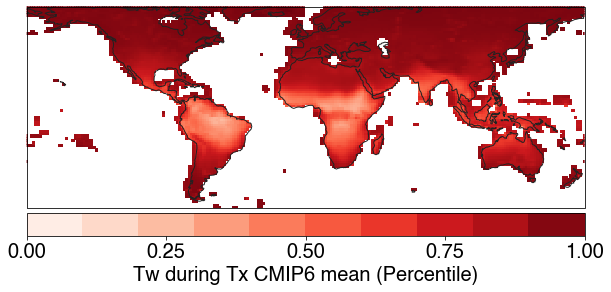

In [269]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

# data = ds_grow_r_t_et.r_t_et.values
data = tw_during_tx_cmip6.tw_during_tx.mean(dim=['model', 'time']).values
c = plt.pcolormesh(cmip6_lon, cmip6_lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw during Tx CMIP6 mean (Percentile)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

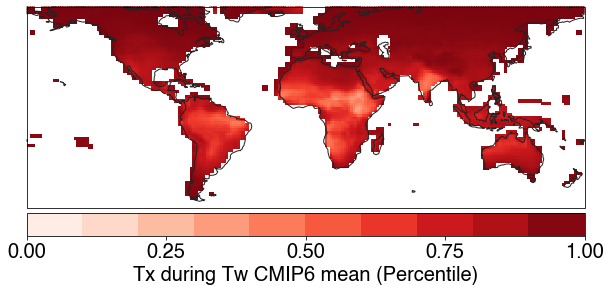

In [270]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

# data = ds_grow_r_t_et.r_t_et.values
data = tx_during_tw_cmip6.tx_during_tw[7,:,:,:].mean(dim=['time']).values
c = plt.pcolormesh(cmip6_lon, cmip6_lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx during Tw CMIP6 mean (Percentile)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

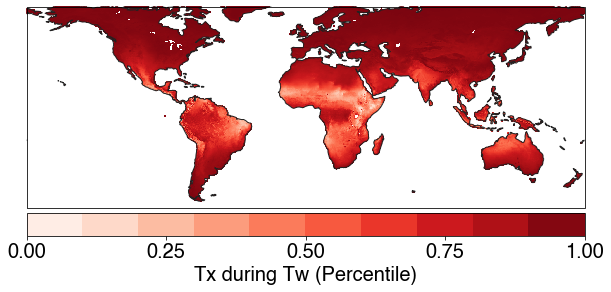

In [271]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

# data = ds_grow_r_t_et.r_t_et.values
data = np.nanmean(tx_during_tw, axis=0)
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx during Tw (Percentile)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

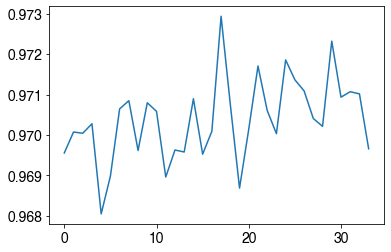

In [272]:
plt.plot(np.nanmean(np.nanmean(tw_during_tw, axis=2), axis=1))

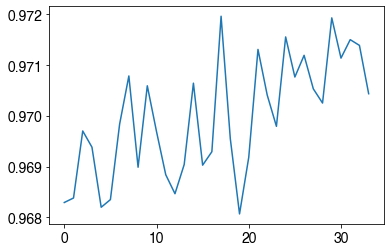

In [273]:
plt.plot(np.nanmean(np.nanmean(tx_during_tx, axis=2), axis=1))

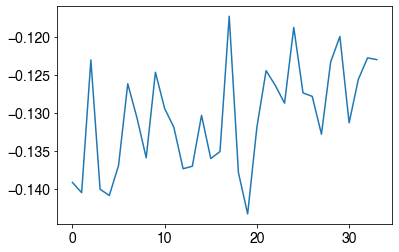

In [274]:
plt.plot(np.nanmean(np.nanmean(tx_diff_from_tw_during_tw, axis=2), axis=1))

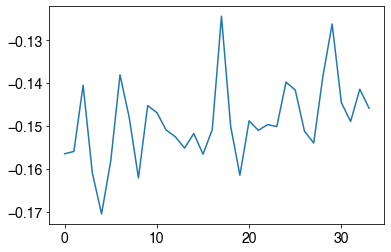

In [275]:
plt.plot(np.nanmean(np.nanmean(tw_diff_from_tx_during_tx, axis=2), axis=1))

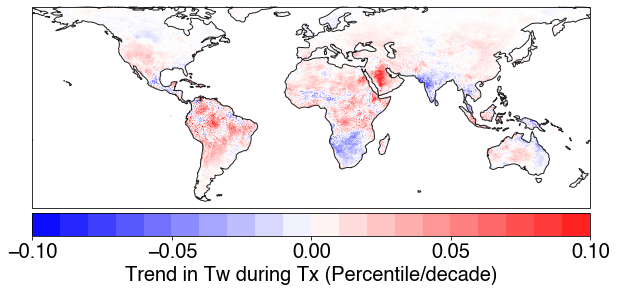

In [276]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

# data = ds_grow_r_t_et.r_t_et.values
data = tw_during_tx_trend * 10
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in Tw during Tx (Percentile/decade)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

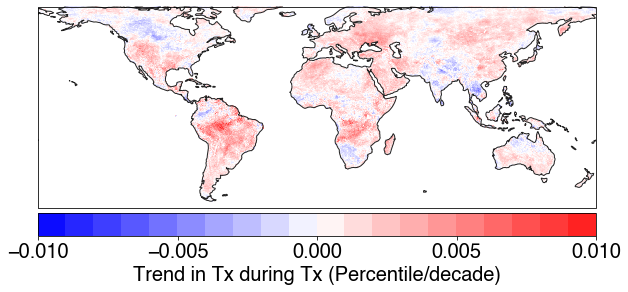

In [277]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.01
v2 = .011
vstep = .001
vlabelstep = .005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

# data = ds_grow_r_t_et.r_t_et.values
data = tx_during_tx_trend * 10
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in Tx during Tx (Percentile/decade)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

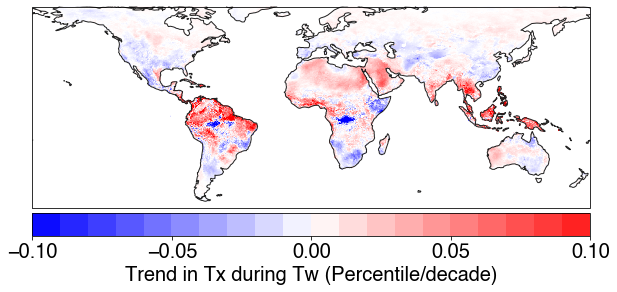

In [278]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

# data = ds_grow_r_t_et.r_t_et.values
data = tx_during_tw_trend * 10
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in Tx during Tw (Percentile/decade)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

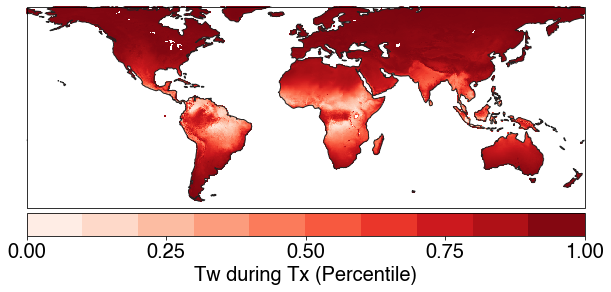

In [279]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

# data = ds_grow_r_t_et.r_t_et.values
data = np.nanmean(tw_during_tx, axis=0)
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw during Tx (Percentile)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

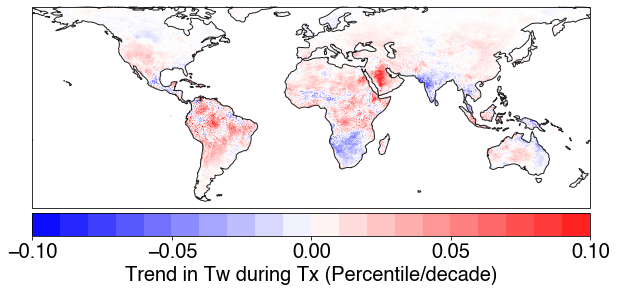

In [280]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

# data = ds_grow_r_t_et.r_t_et.values
data = tw_during_tx_trend * 10
c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in Tw during Tx (Percentile/decade)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

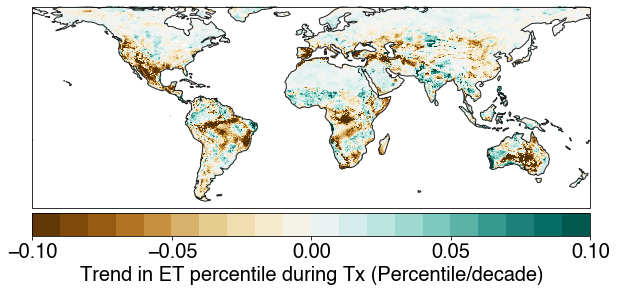

In [281]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = et_during_tx_trend * 10

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in ET percentile during Tx (Percentile/decade)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

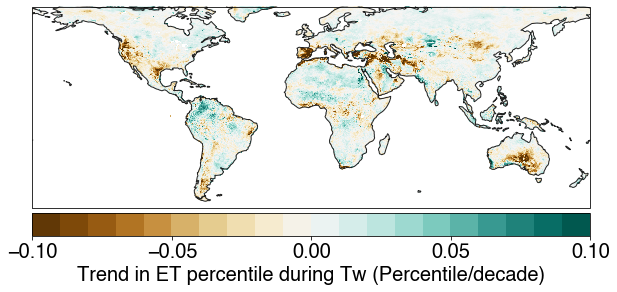

In [282]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = et_during_tw_trend * 10

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in ET percentile during Tw (Percentile/decade)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [283]:
et_during_tw_trend_1d = np.reshape(et_during_tw_trend*10, [et_during_tw_trend.size])
tw_during_tw_trend_1d = np.reshape(tw_during_tw_trend*10, [tw_during_tw_trend.size])
tx_during_tw_trend_1d = np.reshape(tx_during_tw_trend*10, [tx_during_tw_trend.size])

et_during_tx_trend_1d = np.reshape(et_during_tx_trend*10, [et_during_tx_trend.size])
tw_during_tx_trend_1d = np.reshape(tw_during_tx_trend*10, [tw_during_tx_trend.size])
tx_during_tx_trend_1d = np.reshape(tx_during_tx_trend*10, [tx_during_tx_trend.size])

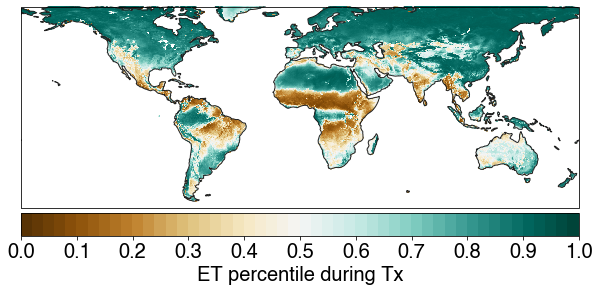

In [284]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .02
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(et_during_tx, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ET percentile during Tx', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

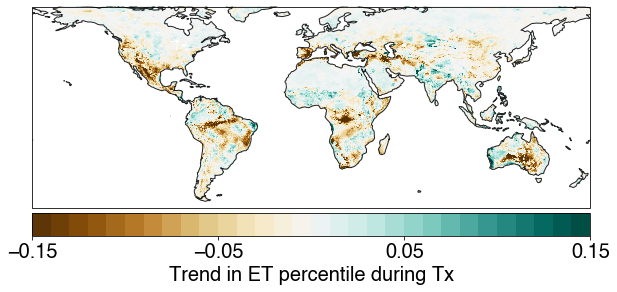

In [285]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.15
v2 = .16
vstep = .01
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = et_during_tx_trend * 10

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in ET percentile during Tx', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

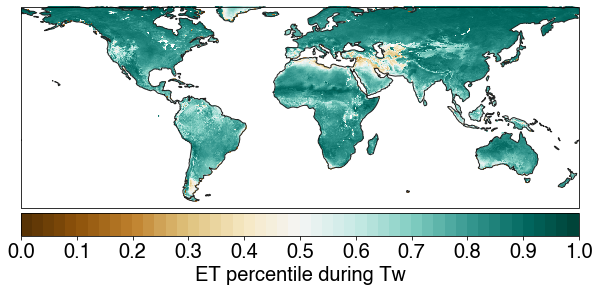

In [286]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .02
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(et_during_tw, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ET percentile during Tw', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [287]:
tw_during_tx.shape

(34, 721, 1440)

In [304]:
lat_global_ind = np.arange(lat.size)
lat_nontropics_ind = np.where(((lat>=30) | (lat<=-30)) & (lat<=60) & (lat>=-65))[0]
lat_nh_ind = np.where((lat>=30) & (lat<=65))[0]
# lat_subtropics_ind = np.where(((lat>=15) & (lat<=30)) | ((lat <= -15) & (lat >= -30)))[0]
lat_tropics_ind = np.where((lat<30) & (lat>-30))[0]
lat_sh_ind = np.where((lat <= -30) & (lat >= -60))[0]

In [331]:
lat_ind_sel = lat_nontropics_ind

tx_during_tw_sel = np.nanmean(tx_during_tw, axis=0)
tx_during_tw_sel = tx_during_tw_sel[lat_ind_sel,:]
tx_during_tw_sel_1d = tx_during_tw_sel.reshape([tx_during_tw_sel.size, 1])

tw_during_tx_sel = np.nanmean(tw_during_tx, axis=0)
tw_during_tx_sel = tw_during_tx_sel[lat_ind_sel,:]
tw_during_tx_sel_1d = tw_during_tx_sel.reshape([tw_during_tx_sel.size, 1])

et_during_tw_sel = np.nanmean(et_during_tw, axis=0)
et_during_tw_sel = et_during_tw_sel[lat_ind_sel,:]
et_during_tw_sel_1d = et_during_tw_sel.reshape([et_during_tw_sel.size, 1])

et_during_tx_sel = np.nanmean(et_during_tx, axis=0)
et_during_tx_sel = et_during_tx_sel[lat_ind_sel,:]
et_during_tx_sel_1d = et_during_tx_sel.reshape([et_during_tx_sel.size, 1])


et_during_tw_trend_sel = et_during_tw_trend[lat_ind_sel, :]*10
et_during_tw_trend_sel_1d = np.reshape(et_during_tw_trend_sel, [et_during_tw_trend_sel.size, 1])

tw_during_tw_trend_sel = tw_during_tw_trend[lat_ind_sel, :]*10
tw_during_tw_trend_sel_1d = np.reshape(tw_during_tw_trend_sel, [tw_during_tw_trend_sel.size, 1])

tx_during_tw_trend_sel = tx_during_tw_trend[lat_ind_sel, :]*10
tx_during_tw_trend_sel_1d = np.reshape(tx_during_tw_trend_sel, [tx_during_tw_trend_sel.size, 1])

et_during_tx_trend_sel = et_during_tx_trend[lat_ind_sel, :]*10
et_during_tx_trend_sel_1d = np.reshape(et_during_tx_trend_sel, [et_during_tx_trend_sel.size, 1])

tw_during_tx_trend_sel = tw_during_tx_trend[lat_ind_sel, :]*10
tw_during_tx_trend_sel_1d = np.reshape(tw_during_tx_trend_sel, [tw_during_tx_trend_sel.size, 1])

tx_during_tx_trend_sel = tx_during_tx_trend[lat_ind_sel, :]*10
tx_during_tx_trend_sel_1d = np.reshape(tx_during_tx_trend_sel, [tx_during_tx_trend_sel.size, 1])


t_et = ds_grow_r_t_et.r_t_et.values
t_et = t_et[lat_ind_sel,:]
t_et_1d = t_et.reshape([t_et.size, 1])

t_et_crop = ds_grow_r_t_et_crop.r_t_et.values
t_et_crop = t_et_crop[lat_ind_sel,:]
t_et_crop_1d = t_et_crop.reshape([t_et_crop.size, 1])

crop_ha_regrid_sel = crop_ha_regrid[lat_ind_sel,:]
crop_ha_regrid_sel_1d = crop_ha_regrid_sel.reshape([crop_ha_regrid_sel.size, 1])

ind = np.where((np.isnan(crop_ha_regrid_sel_1d)) & (~np.isnan(t_et_1d)))[0]
crop_ha_regrid_sel_1d[ind] = 0

In [332]:
t_et_1d.size, tx_during_tx_trend_sel_1d.size, t_et_crop_1d.size, crop_ha_regrid_sel_1d.size

(377280, 377280, 377280, 377280)

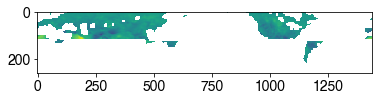

In [333]:
plt.imshow(tx_during_tw_trend_sel)

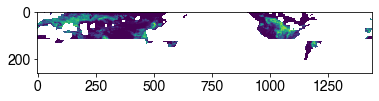

In [334]:
plt.imshow(crop_ha_regrid_sel)

In [335]:
nn = np.where((~np.isnan(tx_during_tw_trend_sel_1d)) & (~np.isnan(t_et_crop_1d)))[0]

data = {'tx_during_tw_trend':tx_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tw_trend':et_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tw_trend':tw_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tx_during_tx_trend':tx_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tx_trend':et_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tx_trend':tw_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'r_t_et':t_et_1d[nn].reshape([nn.size]), \
        'cf':crop_ha_regrid_sel_1d[nn].reshape([nn.size])}

In [355]:
df = pd.DataFrame(data, \
                  columns=['tx_during_tw_trend', 'et_during_tw_trend', 'tw_during_tw_trend', \
                           'tx_during_tx_trend', 'et_during_tx_trend', 'tw_during_tx_trend', \
                           'r_t_et', 'cf'])


mdl1 = smf.ols(formula='tw_during_tw_trend ~ tx_during_tw_trend + et_during_tw_trend + r_t_et + cf', data=df).fit()
mdl2 = smf.ols(formula='tw_during_tw_trend ~ tx_during_tw_trend + et_during_tw_trend + cf', data=df).fit()
mdl3 = smf.ols(formula='tw_during_tw_trend ~ cf', data=df).fit()

mdlx = smf.ols(formula='et_during_tw_trend ~ cf', data=df).fit()

mdl4 = smf.ols(formula='tx_during_tx_trend ~ et_during_tx_trend + r_t_et', data=df).fit()
mdl5 = smf.ols(formula='tx_during_tx_trend ~ et_during_tx_trend', data=df).fit()

mdl6 = smf.ols(formula='tw_during_tx_trend ~ et_during_tx_trend + tx_during_tx_trend + r_t_et', data=df).fit()
mdl7 = smf.ols(formula='tw_during_tx_trend ~ et_during_tx_trend + r_t_et', data=df).fit()
mdl8 = smf.ols(formula='tw_during_tx_trend ~ et_during_tx_trend', data=df).fit()

mdl9 = smf.ols(formula='tx_during_tw_trend ~ et_during_tw_trend + r_t_et', data=df).fit()


In [356]:
mdlx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     et_during_tw_trend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.64
Date:                Fri, 09 Sep 2022   Prob (F-statistic):            0.00111
Time:                        13:21:38   Log-Likelihood:             1.1943e+05
No. Observations:               57002   AIC:                        -2.389e+05
Df Residuals:                   57000   BIC:                        -2.388e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0091      0.000    -52.979      0.000      -0.009      -0.009
cf             0.0015      0.000      3.261      0.001       0.001       0.002
==============================================================================
Omnibus:                    28802.335   Durbin-Watson:                   0.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           296277.408
Skew:                          -2.209   Prob(JB):                         0.00
Kurtosis:                      13.258   Cond. No.                         3.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

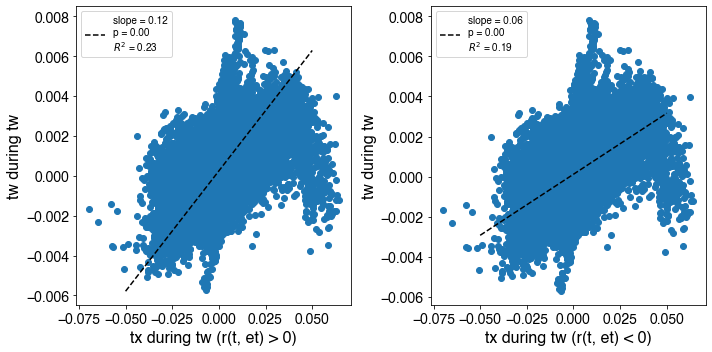

In [105]:
x1 = -.05
x2 = .05
fig, ax = plt.subplots(1,2, figsize=(10,5))

nn = np.where(((~np.isnan(tx_during_tx_trend_sel_1d)) | (~np.isnan(tw_during_tw_trend_sel_1d))) & (t_et_1d > 0))[0]
X = sm.add_constant(tx_during_tw_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tw_trend_sel_1d[nn], X).fit()

ax[0].scatter(tx_during_tw_trend_sel_1d, tw_during_tw_trend_sel_1d)
ax[0].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[0].legend()

ax[0].set_xlabel('tx during tw (r(t, et) > 0)')
ax[0].set_ylabel('tw during tw')



nn = np.where(((~np.isnan(tx_during_tx_trend_sel_1d)) | (~np.isnan(tw_during_tw_trend_sel_1d))) & (t_et_1d < 0))[0]
X = sm.add_constant(tx_during_tw_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tw_trend_sel_1d[nn], X).fit()

ax[1].scatter(tx_during_tw_trend_sel_1d, tw_during_tw_trend_sel_1d)
ax[1].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[1].legend()

ax[1].set_xlabel('tx during tw (r(t, et) < 0)')
ax[1].set_ylabel('tw during tw')

plt.tight_layout()

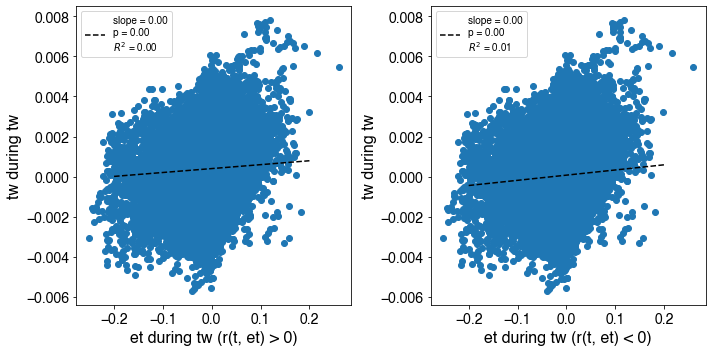

In [48]:
x1 = -.2
x2 = .2
fig, ax = plt.subplots(1,2, figsize=(10,5))

nn = np.where(((~np.isnan(et_during_tw_trend_sel_1d)) | (~np.isnan(tw_during_tw_trend_sel_1d))) & (t_et_1d > 0))[0]
X = sm.add_constant(et_during_tw_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tw_trend_sel_1d[nn], X).fit()

ax[0].scatter(et_during_tw_trend_sel_1d, tw_during_tw_trend_sel_1d)
ax[0].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[0].legend()

ax[0].set_xlabel('et during tw (r(t, et) > 0)')
ax[0].set_ylabel('tw during tw')



nn = np.where(((~np.isnan(et_during_tw_trend_sel_1d)) | (~np.isnan(tw_during_tw_trend_sel_1d))) & (t_et_1d < 0))[0]
X = sm.add_constant(et_during_tw_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tw_trend_sel_1d[nn], X).fit()

ax[1].scatter(et_during_tw_trend_sel_1d, tw_during_tw_trend_sel_1d)
ax[1].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[1].legend()

ax[1].set_xlabel('et during tw (r(t, et) < 0)')
ax[1].set_ylabel('tw during tw')

plt.tight_layout()

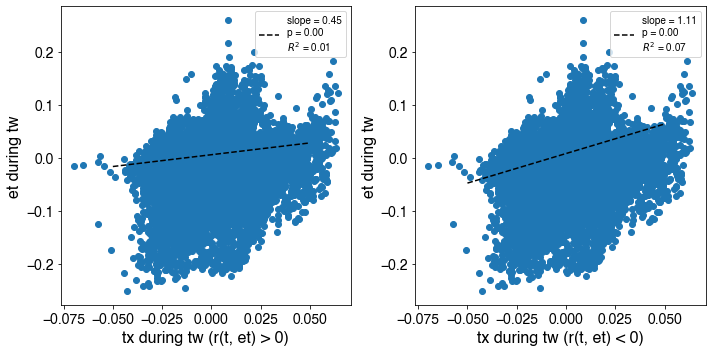

In [53]:
x1 = -.05
x2 = .05
fig, ax = plt.subplots(1,2, figsize=(10,5))

nn = np.where(((~np.isnan(et_during_tw_trend_sel_1d)) | (~np.isnan(tx_during_tw_trend_sel_1d))) & (t_et_1d > 0))[0]
X = sm.add_constant(tx_during_tw_trend_sel_1d[nn])
mdl = sm.OLS(et_during_tw_trend_sel_1d[nn], X).fit()

ax[0].scatter(tx_during_tw_trend_sel_1d, et_during_tw_trend_sel_1d)
ax[0].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[0].legend()

ax[0].set_xlabel('tx during tw (r(t, et) > 0)')
ax[0].set_ylabel('et during tw')



nn = np.where(((~np.isnan(tx_during_tw_trend_sel_1d)) | (~np.isnan(et_during_tw_trend_sel_1d))) & (t_et_1d < 0))[0]
X = sm.add_constant(tx_during_tw_trend_sel_1d[nn])
mdl = sm.OLS(et_during_tw_trend_sel_1d[nn], X).fit()

ax[1].scatter(tx_during_tw_trend_sel_1d, et_during_tw_trend_sel_1d)
ax[1].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[1].legend()

ax[1].set_xlabel('tx during tw (r(t, et) < 0)')
ax[1].set_ylabel('et during tw')

plt.tight_layout()

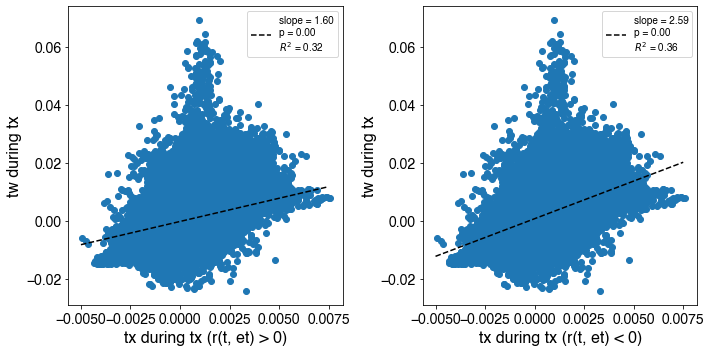

In [49]:
x1 = -.005
x2 = .0075
fig, ax = plt.subplots(1,2, figsize=(10,5))

nn = np.where(((~np.isnan(tx_during_tx_trend_sel_1d)) | (~np.isnan(tw_during_tx_trend_sel_1d))) & (t_et_1d > 0))[0]
X = sm.add_constant(tx_during_tx_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tx_trend_sel_1d[nn], X).fit()

ax[0].scatter(tx_during_tx_trend_sel_1d, tw_during_tx_trend_sel_1d)
ax[0].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[0].legend()

ax[0].set_xlabel('tx during tx (r(t, et) > 0)')
ax[0].set_ylabel('tw during tx')



nn = np.where(((~np.isnan(tx_during_tx_trend_sel_1d)) | (~np.isnan(tw_during_tx_trend_sel_1d))) & (t_et_1d < 0))[0]
X = sm.add_constant(tx_during_tx_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tx_trend_sel_1d[nn], X).fit()

ax[1].scatter(tx_during_tx_trend_sel_1d, tw_during_tx_trend_sel_1d)
ax[1].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[1].legend()

ax[1].set_xlabel('tx during tx (r(t, et) < 0)')
ax[1].set_ylabel('tw during tx')

plt.tight_layout()

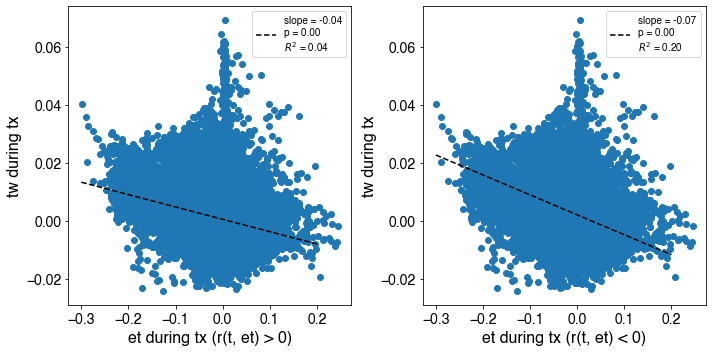

In [51]:
x1 = -.3
x2 = .2
fig, ax = plt.subplots(1,2, figsize=(10,5))

nn = np.where(((~np.isnan(et_during_tx_trend_sel_1d)) | (~np.isnan(tw_during_tx_trend_sel_1d))) & (t_et_1d > 0))[0]
X = sm.add_constant(et_during_tx_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tx_trend_sel_1d[nn], X).fit()

ax[0].scatter(et_during_tx_trend_sel_1d, tw_during_tx_trend_sel_1d)
ax[0].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[0].legend()

ax[0].set_xlabel('et during tx (r(t, et) > 0)')
ax[0].set_ylabel('tw during tx')



nn = np.where(((~np.isnan(et_during_tx_trend_sel_1d)) | (~np.isnan(tw_during_tx_trend_sel_1d))) & (t_et_1d < 0))[0]
X = sm.add_constant(et_during_tx_trend_sel_1d[nn])
mdl = sm.OLS(tw_during_tx_trend_sel_1d[nn], X).fit()

ax[1].scatter(et_during_tx_trend_sel_1d, tw_during_tx_trend_sel_1d)
ax[1].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[1].legend()

ax[1].set_xlabel('et during tx (r(t, et) < 0)')
ax[1].set_ylabel('tw during tx')

plt.tight_layout()

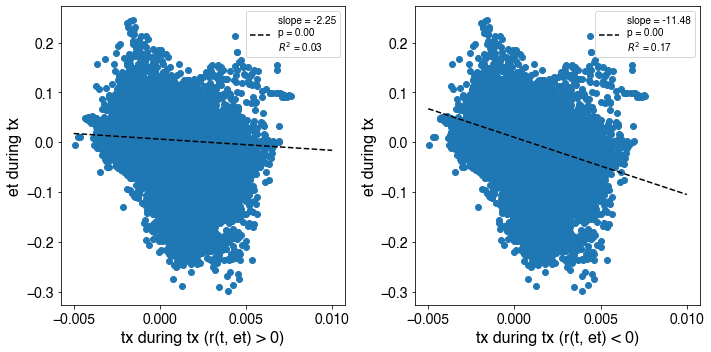

In [55]:
x1 = -.005
x2 = .01
fig, ax = plt.subplots(1,2, figsize=(10,5))

nn = np.where(((~np.isnan(et_during_tx_trend_sel_1d)) | (~np.isnan(tx_during_tx_trend_sel_1d))) & (t_et_1d > 0))[0]
X = sm.add_constant(tx_during_tx_trend_sel_1d[nn])
mdl = sm.OLS(et_during_tx_trend_sel_1d[nn], X).fit()

ax[0].scatter(tx_during_tx_trend_sel_1d, et_during_tx_trend_sel_1d)
ax[0].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[0].legend()

ax[0].set_xlabel('tx during tx (r(t, et) > 0)')
ax[0].set_ylabel('et during tx')



nn = np.where(((~np.isnan(et_during_tx_trend_sel_1d)) | (~np.isnan(tx_during_tx_trend_sel_1d))) & (t_et_1d < 0))[0]
X = sm.add_constant(tx_during_tx_trend_sel_1d[nn])
mdl = sm.OLS(et_during_tx_trend_sel_1d[nn], X).fit()

ax[1].scatter(tx_during_tx_trend_sel_1d, et_during_tx_trend_sel_1d)
ax[1].plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', label='slope = %.2f\np = %.2f\n$R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))
ax[1].legend()

ax[1].set_xlabel('tx during tx (r(t, et) < 0)')
ax[1].set_ylabel('et during tx')

plt.tight_layout()

In [23]:
nn = np.where((~np.isnan(t_et_1d)) & (~np.isnan(tx_during_tw_sel_1d)))[0]
X = sm.add_constant(t_et_1d[nn])
mdl = sm.OLS(tx_during_tw_sel_1d[nn], X).fit()

nn = np.where((~np.isnan(t_et_1d)) & (~np.isnan(et_during_tw_sel_1d)))[0]
X = sm.add_constant(t_et_1d[nn])
mdl_et = sm.OLS(et_during_tw_sel_1d[nn], X).fit()

Text(0.5, 1.0, 'Slope = 0.09, p = 0.00, $R^2$ = 0.10')

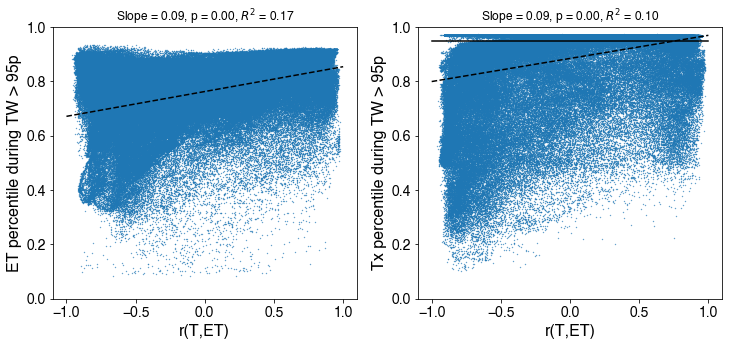

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].set_ylim([0, 1])
ax[0].scatter(t_et_1d, et_during_tw_sel_1d,s=.1)
x1 = -1
x2 = 1
ax[0].plot([x1,x2], [mdl_et.params[0]+x1*mdl_et.params[1], mdl_et.params[0]+x2*mdl_et.params[1]], '--k')
ax[0].set_xlabel('r(T,ET)')
ax[0].set_ylabel('ET percentile during TW > 95p')
ax[0].set_title('Slope = %.2f, p = %.2f, $R^2$ = %.2f'%(mdl_et.params[1], mdl_et.pvalues[1], mdl_et.rsquared))

ax[1].set_ylim([0, 1])
ax[1].scatter(t_et_1d, tx_during_tw_sel_1d,s=.1)
x1 = -1
x2 = 1
ax[1].plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k')
ax[1].plot([x1,x2], [.95, .95], '-k')
ax[1].set_xlabel('r(T,ET)')
ax[1].set_ylabel('Tx percentile during TW > 95p')
ax[1].set_title('Slope = %.2f, p = %.2f, $R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))

In [25]:
nn = np.where((~np.isnan(t_et_1d)) & (~np.isnan(tw_during_tx_sel_1d)))[0]
X = sm.add_constant(t_et_1d[nn])
mdl = sm.OLS(tw_during_tx_sel_1d[nn], X).fit()

nn = np.where((~np.isnan(t_et_1d)) & (~np.isnan(et_during_tx_sel_1d)))[0]
X = sm.add_constant(t_et_1d[nn])
mdl_et = sm.OLS(et_during_tx_sel_1d[nn], X).fit()

Text(0.5, 1.0, 'Slope = 0.06, p = 0.00, $R^2$ = 0.04')

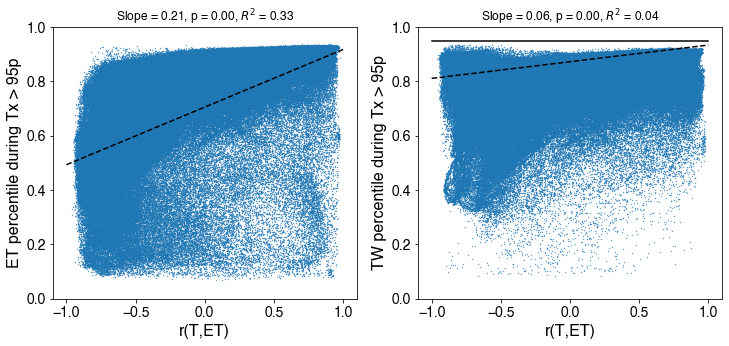

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].set_ylim([0, 1])
ax[0].scatter(t_et_1d, et_during_tx_sel_1d,s=.1)
x1 = -1
x2 = 1
ax[0].plot([x1,x2], [mdl_et.params[0]+x1*mdl_et.params[1], mdl_et.params[0]+x2*mdl_et.params[1]], '--k')
# ax[1].plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k')
# ax[1].plot([x1,x2], [0,0], '-k')
# ax[1].plot([mdl.params[1], mdl.params[1]], [-.2, .05], '-k')
ax[0].set_xlabel('r(T,ET)')
ax[0].set_ylabel('ET percentile during Tx > 95p')
ax[0].set_title('Slope = %.2f, p = %.2f, $R^2$ = %.2f'%(mdl_et.params[1], mdl_et.pvalues[1], mdl_et.rsquared))

ax[1].set_ylim([0, 1])
ax[1].scatter(t_et_1d, et_during_tw_sel_1d,s=.1)
x1 = -1
x2 = 1
ax[1].plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k')
ax[1].plot([x1,x2], [.95, .95], '-k')
ax[1].set_xlabel('r(T,ET)')
ax[1].set_ylabel('TW percentile during Tx > 95p')
ax[1].set_title('Slope = %.2f, p = %.2f, $R^2$ = %.2f'%(mdl.params[1], mdl.pvalues[1], mdl.rsquared))



In [27]:
r_t_et_bins = np.arange(-1, 1.01, .1)

binned_tw_during_tx = np.full(r_t_et_bins.size, np.nan)
binned_tx_during_tw = np.full(r_t_et_bins.size, np.nan)
binned_et_during_tx = np.full(r_t_et_bins.size, np.nan)
binned_et_during_tw = np.full(r_t_et_bins.size, np.nan)

binned_tw_during_tx_nocrop = np.full(r_t_et_bins.size, np.nan)
binned_tx_during_tw_nocrop = np.full(r_t_et_bins.size, np.nan)
binned_et_during_tx_nocrop = np.full(r_t_et_bins.size, np.nan)
binned_et_during_tw_nocrop = np.full(r_t_et_bins.size, np.nan)

for b, bin_val in enumerate(r_t_et_bins):
    if not np.isnan(bin_val):
        if b < r_t_et_bins.size-1:
            ind = np.where((t_et_1d > bin_val) & ((t_et_1d < r_t_et_bins[b+1])))[0]
            binned_tw_during_tx[b] = np.nanmean(tw_during_tx_sel_1d[ind])
            binned_tx_during_tw[b] = np.nanmean(tx_during_tw_sel_1d[ind])

            binned_et_during_tx[b] = np.nanmean(et_during_tx_sel_1d[ind])
            binned_et_during_tw[b] = np.nanmean(et_during_tw_sel_1d[ind])
        else:
            ind = np.where((t_et_1d > bin_val))[0]
            binned_tw_during_tx[b] = np.nanmean(tw_during_tx_sel_1d[ind])
            binned_tx_during_tw[b] = np.nanmean(tx_during_tw_sel_1d[ind])

            binned_et_during_tx[b] = np.nanmean(et_during_tx_sel_1d[ind])
            binned_et_during_tw[b] = np.nanmean(et_during_tw_sel_1d[ind])
            
            
for b, bin_val in enumerate(r_t_et_bins):
    if not np.isnan(bin_val):
        if b < r_t_et_bins.size-1:
            ind = np.where((crop_ha_regrid_sel_1d < .1) & (t_et_crop_1d > bin_val) & ((t_et_crop_1d < r_t_et_bins[b+1])))[0]
            binned_tw_during_tx_nocrop[b] = np.nanmean(tw_during_tx_sel_1d[ind])
            binned_tx_during_tw_nocrop[b] = np.nanmean(tx_during_tw_sel_1d[ind])

            binned_et_during_tx_nocrop[b] = np.nanmean(et_during_tx_sel_1d[ind])
            binned_et_during_tw_nocrop[b] = np.nanmean(et_during_tw_sel_1d[ind])
        else:
            ind = np.where((crop_ha_regrid_sel_1d < .1) & (t_et_crop_1d > bin_val))[0]
            binned_tw_during_tx_nocrop[b] = np.nanmean(tw_during_tx_sel_1d[ind])
            binned_tx_during_tw_nocrop[b] = np.nanmean(tx_during_tw_sel_1d[ind])

            binned_et_during_tx_nocrop[b] = np.nanmean(et_during_tx_sel_1d[ind])
            binned_et_during_tw_nocrop[b] = np.nanmean(et_during_tw_sel_1d[ind])
        

In [28]:
cf_bins = np.arange(0, .81, .1)

binned_tw_during_tx_cf = np.full(cf_bins.size, np.nan)
binned_tx_during_tw_cf = np.full(cf_bins.size, np.nan)
binned_et_during_tx_cf = np.full(cf_bins.size, np.nan)
binned_et_during_tw_cf = np.full(cf_bins.size, np.nan)

binned_tw_during_tx_rtet_of_cf = np.full(cf_bins.size, np.nan)
binned_tx_during_tw_rtet_of_cf = np.full(cf_bins.size, np.nan)
binned_et_during_tx_rtet_of_cf = np.full(cf_bins.size, np.nan)
binned_et_during_tw_rtet_of_cf = np.full(cf_bins.size, np.nan)

binned_r_t_et_cf = np.full(cf_bins.size, np.nan)

for b, bin_val in enumerate(cf_bins):
    if not np.isnan(bin_val):
        if b < cf_bins.size-1:
            ind = np.where((crop_ha_regrid_sel_1d > bin_val) & ((crop_ha_regrid_sel_1d < cf_bins[b+1])))[0]
            binned_tw_during_tx_cf[b] = np.nanmean(tw_during_tx_sel_1d[ind])
            binned_tx_during_tw_cf[b] = np.nanmean(tx_during_tw_sel_1d[ind])
            
            binned_et_during_tx_cf[b] = np.nanmean(et_during_tx_sel_1d[ind])
            binned_et_during_tw_cf[b] = np.nanmean(et_during_tw_sel_1d[ind])

            
            binned_r_t_et_cf[b] = np.nanmean(t_et_crop_1d[ind])

        

Text(0, 0.5, 'Mean r(T, ET)')

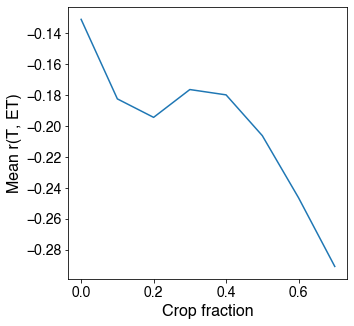

In [29]:
plt.figure(figsize=(5,5))
plt.plot(cf_bins, binned_r_t_et_cf)
plt.xlabel('Crop fraction')
plt.ylabel('Mean r(T, ET)')

In [30]:
data = {'tx_during_tw':tx_during_tw_sel_1d.reshape([tx_during_tw_sel_1d.size]), \
        'tw_during_tx':tw_during_tx_sel_1d.reshape([tw_during_tx_sel_1d.size]), \
        'et_during_tw':et_during_tw_sel_1d.reshape([et_during_tw_sel_1d.size]), \
        'et_during_tx':et_during_tx_sel_1d.reshape([et_during_tx_sel_1d.size]), \
        'r_t_et':t_et_crop_1d.reshape([t_et_crop_1d.size]), \
        'cf':crop_ha_regrid_sel_1d.reshape([crop_ha_regrid_sel_1d.size])}

df = pd.DataFrame(data, \
                  columns=['tw_during_tx', 'tx_during_tw', 'et_during_tw', 'et_during_tx', 'r_t_et', 'cf'])


mdl1 = smf.ols(formula='tx_during_tw ~ r_t_et + cf', data=df).fit()
mdl2 = smf.ols(formula='tw_during_tx ~ r_t_et + cf', data=df).fit()
mdl3 = smf.ols(formula='et_during_tw ~ r_t_et + cf', data=df).fit()
mdl4 = smf.ols(formula='et_during_tx ~ r_t_et + cf', data=df).fit()

In [31]:
mdl4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           et_during_tx   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                 1.438e+04
Date:                Tue, 23 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:47:13   Log-Likelihood:                 7752.6
No. Observations:              109925   AIC:                        -1.550e+04
Df Residuals:                  109922   BIC:                        -1.547e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6094      0.001    678.506      0.000       0.608       0.611
r_t_et         0.1974      0.001    160.772      0.000       0.195       0.200
cf             0.1888      0.003     68.760      0.000       0.183       0.194
==============================================================================
Omnibus:                     8887.797   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9630.112
Skew:                          -0.686   Prob(JB):                         0.00
Kurtosis:                       2.532   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
mdl3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           et_during_tw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     688.0
Date:                Tue, 23 Aug 2022   Prob (F-statistic):          1.12e-297
Time:                        10:47:19   Log-Likelihood:             1.0039e+05
No. Observations:              109925   AIC:                        -2.008e+05
Df Residuals:                  109922   BIC:                        -2.007e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7830      0.000   2024.937      0.000       0.782       0.784
r_t_et         0.0193      0.001     36.580      0.000       0.018       0.020
cf             0.0113      0.001      9.566      0.000       0.009       0.014
==============================================================================
Omnibus:                    44172.348   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           187683.233
Skew:                          -1.984   Prob(JB):                         0.00
Kurtosis:                       8.023   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
mdl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tw_during_tx   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     3445.
Date:                Tue, 23 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:47:22   Log-Likelihood:                 8711.8
No. Observations:              109925   AIC:                        -1.742e+04
Df Residuals:                  109922   BIC:                        -1.739e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7197      0.001    808.318      0.000       0.718       0.721
r_t_et         0.0586      0.001     48.126      0.000       0.056       0.061
cf             0.1956      0.003     71.854      0.000       0.190       0.201
==============================================================================
Omnibus:                    12089.458   Durbin-Watson:                   0.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15951.341
Skew:                          -0.920   Prob(JB):                         0.00
Kurtosis:                       2.686   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tx_during_tw   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     8259.
Date:                Tue, 23 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:47:24   Log-Likelihood:                 36875.
No. Observations:              109925   AIC:                        -7.374e+04
Df Residuals:                  109922   BIC:                        -7.372e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7748      0.001   1124.341      0.000       0.773       0.776
r_t_et         0.1048      0.001    111.242      0.000       0.103       0.107
cf             0.1570      0.002     74.527      0.000       0.153       0.161
==============================================================================
Omnibus:                    11110.251   Durbin-Watson:                   0.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14737.457
Skew:                          -0.892   Prob(JB):                         0.00
Kurtosis:                       2.814   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

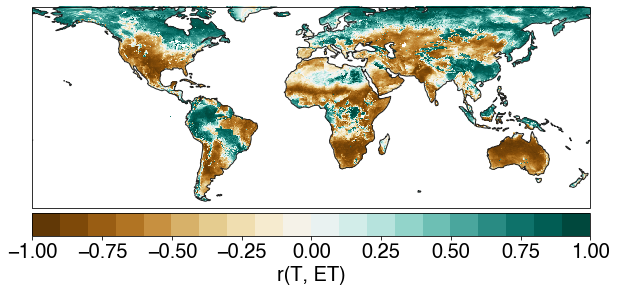

In [35]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(T, ET)', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

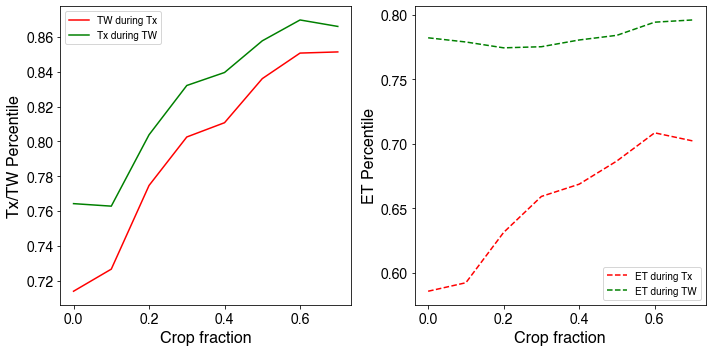

In [36]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(cf_bins, binned_tw_during_tx_cf, '-r', label='TW during Tx')
ax[0].plot(cf_bins, binned_tx_during_tw_cf, '-g', label='Tx during TW')
ax[0].set_ylabel('Tx/TW Percentile')
ax[0].set_xlabel('Crop fraction')

ax[1].plot(cf_bins, binned_et_during_tx_cf, '--r', label='ET during Tx')
ax[1].plot(cf_bins, binned_et_during_tw_cf, '--g', label='ET during TW')
ax[1].set_ylabel('ET Percentile')
ax[1].set_xlabel('Crop fraction')

ax[0].legend()
ax[1].legend()
plt.tight_layout()

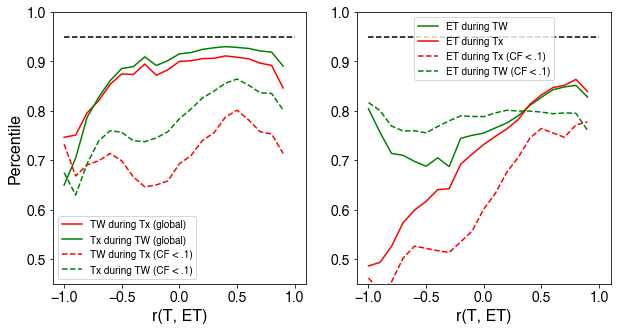

In [37]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_xlim([-1.1,1.1])
ax[0].set_ylim([.45, 1])
ax[0].plot(r_t_et_bins, binned_tw_during_tx, '-r', label='TW during Tx (global)')
ax[0].plot(r_t_et_bins, binned_tx_during_tw, '-g', label='Tx during TW (global)')

ax[0].plot(r_t_et_bins, binned_tw_during_tx_nocrop, '--r', label='TW during Tx (CF < .1)')
ax[0].plot(r_t_et_bins, binned_tx_during_tw_nocrop, '--g', label='Tx during TW (CF < .1)')

ax[1].set_xlim([-1.1,1.1])
ax[1].set_ylim([.45, 1])

ax[1].plot(r_t_et_bins, binned_et_during_tw, '-g', label='ET during TW')
ax[1].plot(r_t_et_bins, binned_et_during_tx, '-r', label='ET during Tx')

ax[1].plot(r_t_et_bins, binned_et_during_tx_nocrop, '--r', label='ET during Tx (CF < .1)')
ax[1].plot(r_t_et_bins, binned_et_during_tw_nocrop, '--g', label='ET during TW (CF < .1)')

ax[0].plot([-1, 1], [0.95, 0.95], '--k')
ax[1].plot([-1, 1], [0.95, 0.95], '--k')

# plt.plot([0, 0], [0.85, 1], '--k')
ax[0].set_xlabel('r(T, ET)')
ax[1].set_xlabel('r(T, ET)')
ax[0].set_ylabel('Percentile')
ax[0].legend()
ax[1].legend()

NameError: name 'hw_perc_tx_during_tw' is not defined

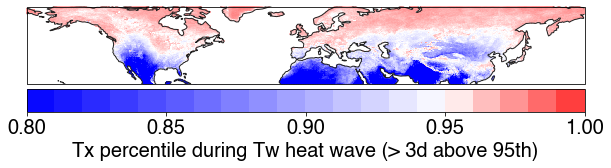

In [41]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, 20])

v1 = .8
v2 = 1.01
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=.95, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(hw_perc_tx_during_tw, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx percentile during Tw heat wave (> 3d above 95th)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

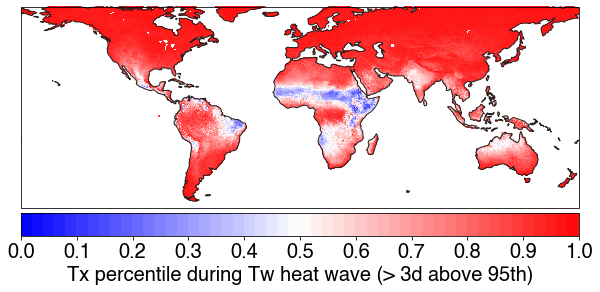

In [116]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .02
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(hw_perc_tx_during_tw, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx percentile during Tw heat wave (> 3d above 95th)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

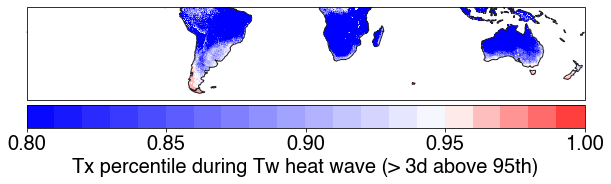

In [151]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, -60, 0])

v1 = .8
v2 = 1.01
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=.95, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean(hw_perc_tx_during_tw, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx percentile during Tw heat wave (> 3d above 95th)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

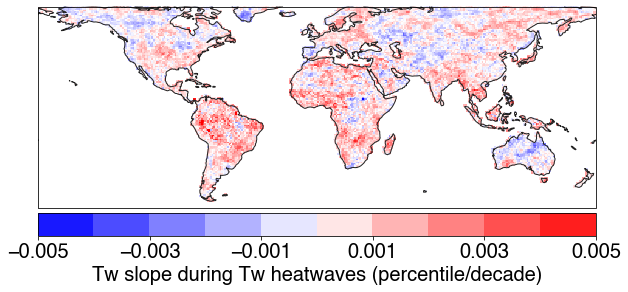

In [50]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.005
v2 = .0051
vstep = .001
vlabelstep = .002

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = hw_perc_tw_lowres_slope*10

c = plt.pcolormesh(lon_lowres, lat_lowres, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw slope during Tw heatwaves (percentile/decade)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

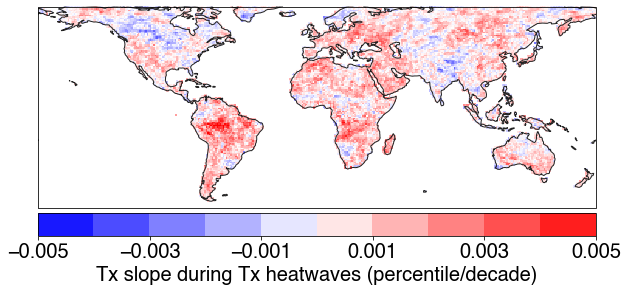

In [49]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.005
v2 = .0051
vstep = .001
vlabelstep = .002

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = hw_perc_tx_lowres_slope*10

c = plt.pcolormesh(lon_lowres, lat_lowres, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx slope during Tx heatwaves (percentile/decade)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [59]:
hw_perc_tx_lowres_slope_1d = hw_perc_tx_lowres_slope.reshape([hw_perc_tx_lowres_slope.size,1])
n_nonnan = np.where(~np.isnan(hw_perc_tx_lowres_slope_1d))[0].size
np.where(hw_perc_tx_lowres_slope_1d>0)[0].size/n_nonnan

0.6452854122621564

In [60]:
hw_perc_tw_lowres_slope_1d = hw_perc_tw_lowres_slope.reshape([hw_perc_tw_lowres_slope.size,1])
n_nonnan = np.where(~np.isnan(hw_perc_tw_lowres_slope_1d))[0].size
np.where(hw_perc_tw_lowres_slope_1d>0)[0].size/n_nonnan

0.6152607036880033

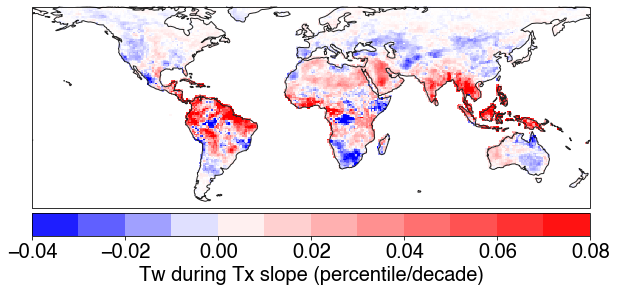

In [42]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.04
v2 = .081
vstep = .01
vlabelstep = .02

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = hw_perc_tw_during_tx_lowres_slope*10

c = plt.pcolormesh(lon_lowres, lat_lowres, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw during Tx slope (percentile/decade)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

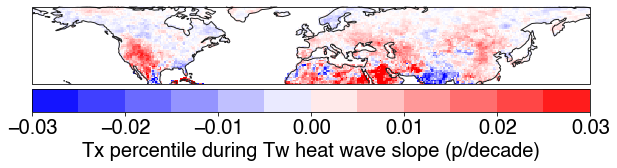

In [43]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, 20])

v1 = -.03
v2 = .031
vstep = .005
vlabelstep = .01

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = hw_perc_tx_during_tw_lowres_slope*10

c = plt.pcolormesh(lon_lowres, lat_lowres, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx percentile during Tw heat wave slope (p/decade)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

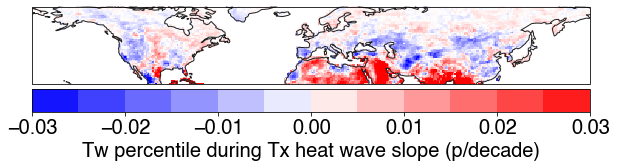

In [44]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, 20])

v1 = -.03
v2 = .031
vstep = .005
vlabelstep = .01

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = hw_perc_tw_during_tx_lowres_slope*10

c = plt.pcolormesh(lon_lowres, lat_lowres, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw percentile during Tx heat wave slope (p/decade)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [136]:
dayoffset_tw = []
dayoffset_tx_during_tw = []
dayoffset_tx = []
dayoffset_tw_during_tx = []

region = 'tropics'
q = 0
l = 7

for year in yearRange:
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tx_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tx.append(pickle.load(f))
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tw_during_tx_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tw_during_tx.append(pickle.load(f))
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tw_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tw.append(pickle.load(f))
    with open('%s/heat-wave-days/hw-dayoffset/dayoffset_tx_during_tw_%s_%d_%d_%d'%(dirHeatData, region, l, q, year), 'rb') as f:
        dayoffset_tx_during_tw.append(pickle.load(f))

dayoffset_tx = np.array(dayoffset_tx)
dayoffset_tw_during_tx = np.array(dayoffset_tw_during_tx)

dayoffset_tw = np.array(dayoffset_tw)
dayoffset_tx_during_tw = np.array(dayoffset_tx_during_tw)

In [141]:
f1 = []
f2 = []

max_tx_during_tx = []
max_tw_during_tx = []
max_tw_during_tw = []
max_tx_during_tw = []

for y, year in enumerate(yearRange):
    ind_tx_during_tw_neg = np.where(np.nanmean(dayoffset_tx_during_tw[y][:,1:], axis=1)<0)[0]
    ind_tx_during_tw_pos = np.where(np.nanmean(dayoffset_tx_during_tw[y][:,1:], axis=1)>0)[0]

    ind_tw_during_tx_neg = np.where(np.nanmean(dayoffset_tw_during_tx[y][:,1:], axis=1)<0)[0]
    ind_tw_during_tx_pos = np.where(np.nanmean(dayoffset_tw_during_tx[y][:,1:], axis=1)>0)[0]
    
    max_tx_during_tx.append(np.nanmean(np.nanmax(dayoffset_tx[y][:, :], axis=1)))
    max_tw_during_tx.append(np.nanmean(np.nanmax(dayoffset_tw_during_tx[y][:, :], axis=1)))
    max_tw_during_tw.append(np.nanmean(np.nanmax(dayoffset_tw[y][:, :], axis=1)))
    max_tx_during_tw.append(np.nanmean(np.nanmax(dayoffset_tx_during_tw[y][:, :], axis=1)))
    
    f1.append(ind_tx_during_tw_pos.size/(ind_tx_during_tw_neg.size+ind_tx_during_tw_pos.size))
    f2.append(ind_tw_during_tx_pos.size/(ind_tw_during_tx_neg.size+ind_tw_during_tx_pos.size))

f1 = np.array(f1)
f2 = np.array(f2)

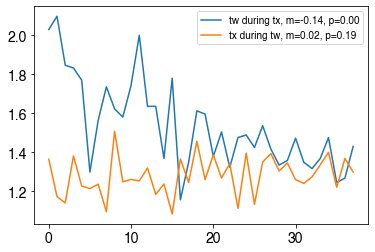

In [142]:
X = sm.add_constant(yearRange)
mdl1 = sm.OLS(max_tx_during_tw,X).fit()

X = sm.add_constant(yearRange)
mdl2 = sm.OLS(max_tw_during_tx,X).fit()


plt.plot(max_tw_during_tx, label='tw during tx, m=%.2f, p=%.2f'%(mdl2.params[1]*10, mdl2.pvalues[1]))
plt.plot(max_tx_during_tw, label='tx during tw, m=%.2f, p=%.2f'%(mdl1.params[1]*10, mdl1.pvalues[1]))
plt.legend()

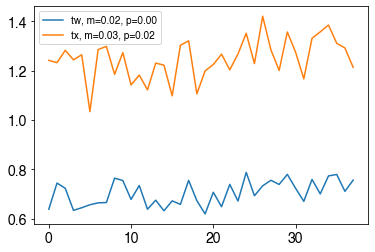

In [143]:
X = sm.add_constant(yearRange)
mdl1 = sm.OLS(max_tx_during_tx,X).fit()

X = sm.add_constant(yearRange)
mdl2 = sm.OLS(max_tw_during_tw,X).fit()

plt.plot(max_tw_during_tw, label='tw, m=%.2f, p=%.2f'%(mdl2.params[1]*10, mdl2.pvalues[1]))
plt.plot(max_tx_during_tx, label='tx, m=%.2f, p=%.2f'%(mdl1.params[1]*10, mdl1.pvalues[1]))
plt.legend()

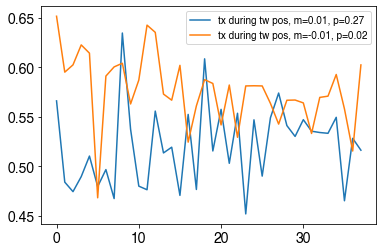

In [144]:
X = sm.add_constant(yearRange)
mdl1 = sm.OLS(f1,X).fit()

X = sm.add_constant(yearRange)
mdl2 = sm.OLS(f2,X).fit()

plt.plot(f1, label='tx during tw pos, m=%.2f, p=%.2f'%(mdl1.params[1]*10, mdl1.pvalues[1]))
plt.plot(f2, label='tx during tw pos, m=%.2f, p=%.2f'%(mdl2.params[1]*10, mdl2.pvalues[1]))
plt.legend()

In [145]:
plt.plot(np.nanmedian(dayoffset_tw[ind_tx_during_tw_pos,:], axis=0), label='tw, n=%.2f'%(ind_tx_during_tw_pos.size/dayoffset_tw.shape[0]))
plt.plot(np.nanmedian(dayoffset_tx_during_tw[ind_tx_during_tw_pos,:], axis=0), label='tx during tw')
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

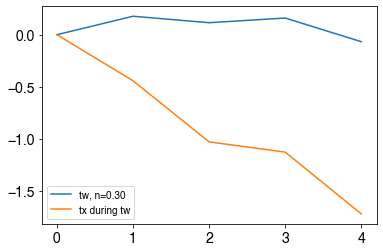

In [14]:
plt.plot(np.nanmedian(dayoffset_tw[ind_tx_during_tw_neg,:], axis=0), label='tw, n=%.2f'%(ind_tx_during_tw_neg.size/dayoffset_tw.shape[0]))
plt.plot(np.nanmedian(dayoffset_tx_during_tw[ind_tx_during_tw_neg,:], axis=0), label='tx during tw')
plt.legend()

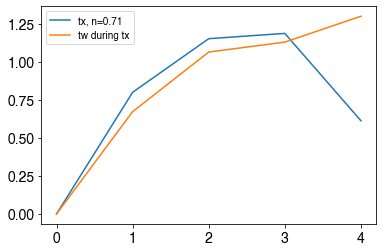

In [15]:
plt.plot(np.nanmedian(dayoffset_tx[ind_tw_during_tx_pos,:], axis=0), label='tx, n=%.2f'%(ind_tw_during_tx_pos.size/dayoffset_tx.shape[0]))
plt.plot(np.nanmedian(dayoffset_tw_during_tx[ind_tw_during_tx_pos,:], axis=0), label='tw during tx')
plt.legend()

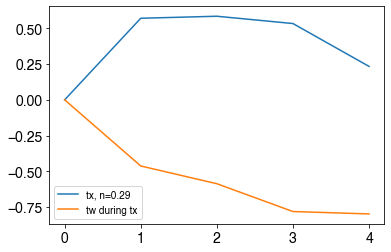

In [16]:
plt.plot(np.nanmedian(dayoffset_tx[ind_tw_during_tx_neg,:], axis=0), label='tx, n=%.2f'%(ind_tw_during_tx_neg.size/dayoffset_tx.shape[0]))
plt.plot(np.nanmedian(dayoffset_tw_during_tx[ind_tw_during_tx_neg,:], axis=0), label='tw during tx')
plt.legend()

In [17]:
np.nanmean(lens_tw)

5.0

In [39]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData):
    wave_days_t_max_trends = xr.apply_ufunc(new_linregress, wave_days_t_max_xr.time, wave_days_t_max_xr.t_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_t_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_t_max_trends = pickle.load(f)

NameError: name 'wave_days_t_max_xr' is not defined

In [25]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData):
    wave_days_tw_max_trends = xr.apply_ufunc(new_linregress, wave_days_tw_max_xr.time, wave_days_tw_max_xr.tw_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_tw_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_tw_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_tw_max_trends = pickle.load(f)

CPU times: user 9min 14s, sys: 6.41 s, total: 9min 20s
Wall time: 9min 58s


In [37]:
wave_days_t_max_trends *= 10
# wave_days_t_min_trends *= 10
wave_days_tw_max_trends *= 10
# wave_days_tw_min_trends *= 10

In [39]:
%%time

sig_trends_only = False
sig_level = 0.1

kdd_trends_zonal_anom = kdd_trends - np.matlib.repmat(np.nanmean(kdd_trends, axis=1), 1, 1).T
gdd_trends_zonal_anom = gdd_trends - np.matlib.repmat(np.nanmean(gdd_trends, axis=1), 1, 1).T

trends_wave_days_t_max_zonal_anom = np.full([wave_days_t_max_trends.shape[0], wave_days_t_max_trends.shape[1], wave_days_t_max_trends.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom = np.full([wave_days_tw_max_trends.shape[0], wave_days_tw_max_trends.shape[1], wave_days_tw_max_trends.shape[2]], np.nan)

# trends_wave_days_t_min_zonal_anom = np.full([wave_days_t_min_trends.shape[0], wave_days_t_min_trends.shape[1], wave_days_t_min_trends.shape[2]], np.nan)
# trends_wave_days_tw_min_zonal_anom = np.full([wave_days_tw_min_trends.shape[0], wave_days_tw_min_trends.shape[1], wave_days_tw_min_trends.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_zonal_anom[:,:,q] = wave_days_t_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_max_trends[:,:,q,0], axis=1), 1, 1).T
    trends_wave_days_tw_max_zonal_anom[:,:,q] = wave_days_tw_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_max_trends[:,:,q,0], axis=1), 1, 1).T
    
#     trends_wave_days_t_min_zonal_anom[:,:,q] = wave_days_t_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_min_trends[:,:,q,0], axis=1), 1, 1).T
#     trends_wave_days_tw_min_zonal_anom[:,:,q] = wave_days_tw_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_min_trends[:,:,q,0], axis=1), 1, 1).T
    
    if sig_trends_only:
        trends_wave_days_t_max_zonal_anom[wave_days_t_max_trends[:,:,q,3] > sig_level, q] = np.nan
        trends_wave_days_tw_max_zonal_anom[wave_days_tw_max_trends[:,:,q,3] > sig_level, q] = np.nan
        
#         trends_wave_days_t_min_zonal_anom[wave_days_t_min_trends[:,:,q,3] > sig_level, q] = np.nan
#         trends_wave_days_tw_min_zonal_anom[wave_days_tw_min_trends[:,:,q,3] > sig_level, q] = np.nan
    

CPU times: user 1.01 s, sys: 20.1 ms, total: 1.03 s
Wall time: 1.03 s


In [40]:
usLat = [150,300]
usLon = [940,1150]
euroLat = [100,200]
euroLon = [0,200]

chinaLat = [150,300]
chinaLon = [350,500]

allLat = [0,-1]
allLon = [0,-1]

selLat = allLat
selLon = allLon

trends_wave_days_t_max_zonal_anom = trends_wave_days_t_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
trends_wave_days_tw_max_zonal_anom = trends_wave_days_tw_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
crop_ha_regrid = crop_ha_regrid[selLat[0]:selLat[1],selLon[0]:selLon[1]]

NameError: name 'crop_ha_regrid' is not defined

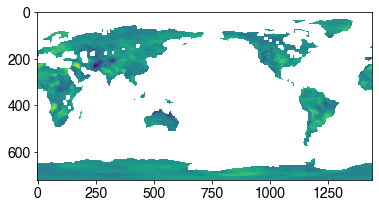

In [41]:
plt.imshow(trends_wave_days_tw_max_zonal_anom[:,:,5])

In [98]:
crop_ha_regrid_1d = np.reshape(crop_ha_regrid, [crop_ha_regrid.size, 1])
irrigation_regrid_1d = np.reshape(irrigation_data_regrid, [irrigation_data_regrid.size, 1])

kdd_trends_1d = np.reshape(kdd_trends, [kdd_trends.size, 1])
kdd_trends_zonal_anom_1d = np.reshape(kdd_trends_zonal_anom, [kdd_trends_zonal_anom.size, 1])

gdd_trends_1d = np.reshape(gdd_trends, [gdd_trends.size, 1])
gdd_trends_zonal_anom_1d = np.reshape(gdd_trends_zonal_anom, [gdd_trends_zonal_anom.size, 1])

trends_wave_days_t_max_1d = np.full([wave_days_t_max_trends[:,:,0,0].values.size, wave_days_t_max_trends.values.shape[2]], np.nan)
trends_wave_days_t_max_zonal_anom_1d = np.full([trends_wave_days_t_max_zonal_anom[:,:,0].size, trends_wave_days_t_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_max_1d = np.full([wave_days_tw_max_trends[:,:,0,0].values.size, wave_days_tw_max_trends.values.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom_1d = np.full([trends_wave_days_tw_max_zonal_anom[:,:,0].size, trends_wave_days_tw_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_t_min_1d = np.full([wave_days_t_min_trends[:,:,0,0].values.size, wave_days_t_min_trends.values.shape[2]], np.nan)
trends_wave_days_t_min_zonal_anom_1d = np.full([trends_wave_days_t_min_zonal_anom[:,:,0].size, trends_wave_days_t_min_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_min_1d = np.full([wave_days_tw_min_trends[:,:,0,0].values.size, wave_days_tw_min_trends.values.shape[2]], np.nan)
trends_wave_days_tw_min_zonal_anom_1d = np.full([trends_wave_days_tw_min_zonal_anom[:,:,0].size, trends_wave_days_tw_min_zonal_anom.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_1d[:,q] = np.reshape(wave_days_t_max_trends[:,:,q,0].values, [wave_days_t_max_trends[:,:,q,0].values.size])
    trends_wave_days_t_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_max_zonal_anom[:,:,q], [trends_wave_days_t_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_max_1d[:,q] = np.reshape(wave_days_tw_max_trends[:,:,q,0].values, [wave_days_tw_max_trends[:,:,q,0].values.size])
    trends_wave_days_tw_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_max_zonal_anom[:,:,q], [trends_wave_days_tw_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_t_min_1d[:,q] = np.reshape(wave_days_t_min_trends[:,:,q,0].values, [wave_days_t_min_trends[:,:,q,0].values.size])
    trends_wave_days_t_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_min_zonal_anom[:,:,q], [trends_wave_days_t_min_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_min_1d[:,q] = np.reshape(wave_days_tw_min_trends[:,:,q,0].values, [wave_days_tw_min_trends[:,:,q,0].values.size])
    trends_wave_days_tw_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_min_zonal_anom[:,:,q], [trends_wave_days_tw_min_zonal_anom[:,:,q].size])

In [99]:
q = 5

crop_ha_regrid_1d[crop_ha_regrid_1d==0] = np.nan
# crop_ha_regrid_1d[crop_ha_regrid_1d<1] = np.nan

# nn = np.where((~np.isnan(kdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_kdd = sm.OLS(kdd_trends_zonal_anom_1d[nn], X).fit()

# nn = np.where((~np.isnan(gdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_gdd = sm.OLS(gdd_trends_zonal_anom_1d[nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_t_max = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_min_zonal_anom_1d[:,q], [trends_wave_days_t_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_t_min = sm.OLS(trends_wave_days_t_min_zonal_anom_1d[:,q][nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_tw_max = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_min_zonal_anom_1d[:,q], [trends_wave_days_tw_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_tw_min = sm.OLS(trends_wave_days_tw_min_zonal_anom_1d[:,q][nn], X).fit()

# IRRIGATION DATA
# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_t_max_irr = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_tw_max_irr = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

In [201]:
# plt.scatter(irrigation_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:,q])
# plt.plot([x1, x2], [mdl_wave_days_t_max_irr.params[0], mdl_wave_days_t_max_irr.params[0]+x2*mdl_wave_days_t_max_irr.params[1]], '--k', lw=2)

In [73]:
slopes_t = []
slopes_tw = []
n = 10
for pct in range(0, 101, n):
    crop_ha_regrid_1d_sel = np.where((crop_ha_regrid_1d>pct) & (crop_ha_regrid_1d<pct+n))[0]
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_t_max_partial = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_t.append(mdl_wave_days_t_max_partial.params[1])
    
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_tw_max_partial = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_tw.append(mdl_wave_days_tw_max_partial.params[1])

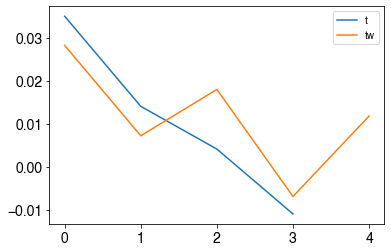

In [74]:
plt.plot(slopes_t, label='t')
plt.plot(slopes_tw, label='tw')
plt.legend()

In [168]:
mdl_wave_days_t_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     105.2
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           3.03e-24
Time:                        17:33:24   Log-Likelihood:                -2131.3
No. Observations:                2782   AIC:                             4267.
Df Residuals:                    2780   BIC:                             4278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9775      0.014     68.788      0.000       0.950       1.005
x1            -0.0151      0.001    -10.255      0.000      -0.018      -0.012
==============================================================================
Omnibus:                      125.622   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.468
Skew:                          -0.537   Prob(JB):                     5.19e-31
Kurtosis:                       2.778   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

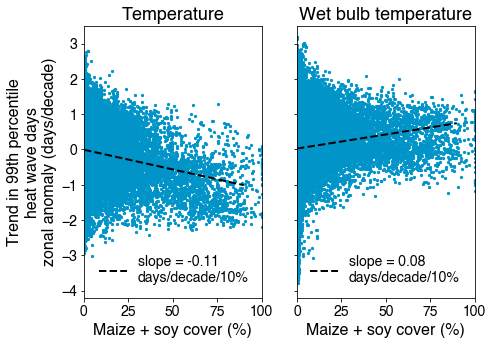

In [100]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,5))

x1 = 0
x2 = 90

ax1.scatter(crop_ha_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax1.plot([x1, x2], [mdl_wave_days_t_max.params[0], mdl_wave_days_t_max.params[0]+x2*mdl_wave_days_t_max.params[1]], '--k', lw=2, \
         label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_t_max.params[1]*10))
ax1.set_title('Temperature', fontsize=18)
ax1.set_xlabel('Maize + soy cover (%)')
ax1.set_ylabel('Trend in 99th percentile\nheat wave days\nzonal anomaly (days/decade)')
ax1.set_xlim([0, 100])
ax1.set_ylim([-4.2, 3.5])
ax1.legend(prop={'size': 14}, frameon=False)

ax2.scatter(crop_ha_regrid_1d, trends_wave_days_tw_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax2.plot([x1, x2], [mdl_wave_days_tw_max.params[0], mdl_wave_days_tw_max.params[0]+x2*mdl_wave_days_tw_max.params[1]], '--k', lw=2, \
        label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_tw_max.params[1]*10))
ax2.set_title('Wet bulb temperature', fontsize=18)
ax2.set_xlabel('Maize + soy cover (%)')
ax2.set_yticks(np.arange(-4, 3.1))
ax2.set_xlim([0, 100])
ax2.set_ylim([-4.2, 3.5])
ax2.legend(prop={'size': 14}, frameon=False)

# plt.savefig('figs/cropland-t-tw-zonal-mean-trends.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

# ax3.scatter(crop_ha_regrid_1d, trends_wave_days_t_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax3.plot([x1, x2], [mdl_wave_days_t_min.params[0], mdl_wave_days_t_min.params[0]+x2*mdl_wave_days_t_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_t_min.params[1]*10))
# ax3.set_title('T_min, q = %d'%q)
# ax3.set_xlabel('Crop cover (%)')
# ax3.set_ylabel('Cold wave days trend\nzonal anomaly\n(days/decade)')
# ax3.set_xlim([0, 100])
# # ax3.set_ylim([-4, 4])
# ax3.legend()

# ax4.scatter(crop_ha_regrid_1d, trends_wave_days_tw_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax4.plot([x1, x2], [mdl_wave_days_tw_min.params[0], mdl_wave_days_tw_min.params[0]+x2*mdl_wave_days_tw_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_tw_min.params[1]*10))
# ax4.set_title('TW_min, q = %d'%q)
# ax4.set_xlabel('Crop cover (%)')
# ax4.set_xlim([0, 100])
# # ax4.set_ylim([-4, 4])
# ax4.legend()


In [72]:
ind_no_crop = np.where((crop_ha_regrid_1d<=1))[0]
ind_low_crop = np.where((crop_ha_regrid_1d>1) & (crop_ha_regrid_1d<=25))[0]
ind_high_crop = np.where((crop_ha_regrid_1d>25))[0]

t_max_trend_no_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_no_crop, q])
t_max_trend_low_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_low_crop, q])
t_max_trend_high_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_high_crop, q])

tw_max_trend_no_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_no_crop, q])
tw_max_trend_low_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_low_crop, q])
tw_max_trend_high_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_high_crop, q])


print(t_max_trend_no_crop, t_max_trend_low_crop, t_max_trend_high_crop)
print(tw_max_trend_no_crop, tw_max_trend_low_crop, tw_max_trend_high_crop)

0.8347558764880052 0.9666224785926698 0.7906920555326428
0.7798830927907219 0.9551428739071759 1.1489443741759706
